In [165]:
import numpy as np
import matplotlib.pyplot as plt

In [166]:
grid = np.full((10, 10), -0.02)
pos = [(9, 0), (6, 7)]
neg = [(2, 0), (4, 5), (0, 9), (9, 9)]
for i, j in pos:
    grid[i, j] = 1.0
for i, j in neg:
    grid[i, j] = -1

print(grid)

[[-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -1.  ]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-1.   -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -1.   -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02  1.   -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [-0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02]
 [ 1.   -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -1.  ]]


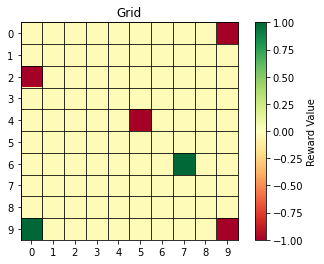

In [167]:
fig, ax = plt.subplots()
im = ax.imshow(grid, cmap='RdYlGn', origin='upper')

ax.set_xticks(range(10))
ax.set_yticks(range(10))

#gridlines on cell boundaries
ax.set_xticks(np.arange(-0.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 10, 1), minor=True)
ax.grid(which='minor', color='black', linewidth=0.8)
ax.tick_params(which='minor', length=0)

plt.colorbar(im, ax=ax, label='Reward Value')
plt.title("Grid")
plt.show()


In [168]:
'''
p chance of taking random step
Getting to green ends the game
ignore invalid steps
'''

'\np chance of taking random step\nGetting to green ends the game\nignore invalid steps\n'

In [169]:
terminal = np.zeros(grid.shape, dtype=bool)
for (i, j) in pos:
    terminal[i, j] = True

#up, down, left, right
actions = {
    0: (-1, 0),
    1: (1, 0),
    2: (0, -1),
    3: (0, 1)
}
action_names = {0: '↑', 1: '↓', 2: '←', 3: '→'}

p_rand = 0.1
gamma = 0.95 #discount factor
eps = 1e-8 #convergence threshold

H, W = grid.shape
all_actions = list(actions.keys())

In [170]:
def step_from(state, act):
    
    i, j = state
    if terminal[i, j]:
        return {(i, j): 1.0}
    
    def result_of(a):
        di, dj = actions[a]
        ni, nj = i + di, j + dj
        if 0 <= ni < H and 0 <= nj < W:
            return (ni, nj)
        return None

    valid_results = {a: result_of(a) for a in all_actions if result_of(a) is not None}

    probs = {}
    intended = result_of(act)
    if intended is not None:
        probs[intended] = probs.get(intended, 0.0) + (1 - p_rand)

    
    p_each = p_rand / len(valid_results)
    for out in valid_results.values():
        probs[out] = probs.get(out, 0.0) + p_each

    total = sum(probs.values())
    
    for s in list(probs.keys()):
        probs[s] /= total

    return probs

In [171]:
#precompute transitions probabilities P_sa
transitions = {} # transition is a dict of dict
for i in range(H):
    for j in range(W):
        transitions[(i, j)] = {}
        for a in all_actions:
            transitions[(i, j)][a] = step_from((i, j), a)

V = np.zeros((H, W))
def value_iteration():
    for (i, j) in zip(*np.where(terminal)):
        V[i, j] = grid[i, j]

    iteration = 0
    while True:
        delta = 0.0
        iteration+=1
        V_old = V.copy()
        for i in range(H):
            for j in range(W):
                if terminal[i, j]:
                    continue
                best = -np.inf
                for a in all_actions:
                    total = 0.0
                    for (ni, nj), p in transitions[(i, j)][a].items():
                        r = grid[ni, nj]
                        if terminal[ni, nj]:
                            total += p*r
                        else:
                            total += p*(r + gamma * V_old[ni, nj])
                    if total > best:
                        best = total
                V[i, j] = best
                delta = max(delta, abs(V[i, j] - V_old[i, j]))
        if delta < eps:
            break

    print(f"Value iteration converged in {iteration} iterations")
    return V

In [172]:
value_iteration()

policy = np.full((H, W), None, dtype=object)

for i in range(H):
    for j in range(W):
        if terminal[i, j]:
            policy[i, j] = None
            continue

        best_a = None
        best_q = -np.inf
        for a in all_actions:
            # skip actions that would move off-grid (invalid intended action)
            di, dj = actions[a]
            ni, nj = i + di, j + dj
            if not (0 <= ni < H and 0 <= nj < W):
                continue

            q = 0.0
            for (si, sj), p in transitions[(i, j)][a].items():
                r = grid[si, sj]
                if terminal[si, sj]:
                    q += p * r
                else:
                    q += p * (r + gamma * V[si, sj])
            if q > best_q:
                best_q = q
                best_a = a

        policy[i, j] = best_a


Value iteration converged in 32 iterations


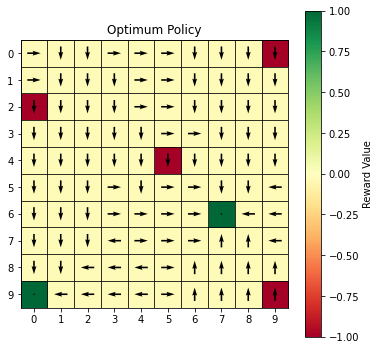

In [173]:

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(grid, cmap='RdYlGn', origin='upper')

# ticks at centers and gridlines on boundaries
ax.set_xticks(np.arange(W))
ax.set_yticks(np.arange(H))
ax.set_xticks(np.arange(-0.5, W, 1), minor=True)
ax.set_yticks(np.arange(-0.5, H, 1), minor=True)
ax.grid(which='minor', color='black', linewidth=0.8)
ax.tick_params(which='minor', length=0)

# build arrow field (U = x-component, V = y-component)
X, Y = np.meshgrid(np.arange(W), np.arange(H))
U = np.zeros((H, W), dtype=float)
V = np.zeros((H, W), dtype=float)

for i in range(H):
    for j in range(W):
        a = policy[i, j]
        if a is None:
            U[i, j] = 0
            V[i, j] = 0
            continue
        di, dj = actions[a]
        U[i, j] = dj
        V[i, j] = di 

ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=2, pivot='middle', color='k')

ax.set_aspect('equal')
plt.colorbar(im, ax=ax, label='Reward Value')
ax.set_title("Optimum Policy")
plt.show()
